<a href="https://colab.research.google.com/github/pritika-vig/MLHC-AgentBasedROI/blob/main/Copy_of_cancer_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langchain openai pillow
!pip install anthropic
!pip install -U langchain-community
!pip install -U langchain-anthropic

  Using cached langchain_community-0.3.22-py3-none-any.whl.metadata (2.4 kB)
  Using cached langchain_core-0.3.56-py3-none-any.whl.metadata (5.9 kB)
Using cached langchain_community-0.3.22-py3-none-any.whl (2.5 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.2 MB/s eta 0:00:00
Using cached langchain_core-0.3.56-py3-none-any.whl (437 kB)
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.1.53
    Uninstalling langchain-core-0.1.53:
      Successfully uninstalled langchain-core-0.1.53
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.0.2
    Uninstalling langchain-text-splitters-0.0.2:
      Successfully uninstalled langchain-text-splitters-0.0.2
  Attempting uninstall: langchain
    Found existing installation: langchain 0.1.20
    Uninstalling langchain-0.1.20:
      Successfully uninstalled langchain-0.1.20
  Attempting uninstall: langchain-community
    Found existing install

In [ ]:
!apt-get install -y openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-5build1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import getpass, os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("ANTHROPIC_API_KEY")


In [ ]:
# Enable debug tracing thorugh the langchain site.
# os.environ["LANGCHAIN_API_KEY"] = "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"
# os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
# os.environ["LANGCHAIN_PROJECT"] = "mlhc-agent"
os.environ["LANGCHAIN_TRACING_V2"] = "false"  # optional for debugging

In [ ]:
# Import standard libraries
import os
import ast
import io
import pdb
from typing import Dict, List, Union

# Import scientific computing and machine learning libraries
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Import image processing libraries
from PIL import Image as PILImage
from IPython.display import display
import openslide

# Import tool decorator from langchain
from langchain.tools import tool

# Global cache for patches
patch_cache = {}

class ResNetModel(nn.Module):
    """Custom ResNet model for patch classification."""

    def __init__(self):
        super(ResNetModel, self).__init__()
        # Load pre-trained ResNet50
        base_model = models.resnet50(weights='IMAGENET1K_V1')

        # Extract feature layers
        layers = list(base_model.children())[:-1]
        self.features = nn.Sequential(*layers)

        # Freeze early layers
        self._freeze_early_layers()

        # Custom classifier
        self.classifier = self._create_classifier()

    def _freeze_early_layers(self):
        """Freeze early layers of the network."""
        ct = 0
        for child in self.features.children():
            ct += 1
            if ct < 7:
                for param in child.parameters():
                    param.requires_grad = False

    def _create_classifier(self):
        """Create a custom multi-layer classifier."""
        return nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        """Forward pass through the network."""
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def initialize_model(model_path):
    """Initialize and load the model."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = ResNetModel()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print("Model loaded successfully")

    return model, device

def create_image_transform():
    """Create image transformation pipeline."""
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

# Initialize model and transform
#dataset_folder_path = "/content/drive/My Drive/Colab Notebooks/Dataset"
MODEL_PATH = '/content/drive/My Drive/Colab Notebooks/Dataset/model_weights_only.pt'
model, device = initialize_model(MODEL_PATH)
transform = create_image_transform()

@tool
def region_of_interest(thumbnail_path: str) -> list:
    """Analyzes a thumbnail and returns coordinates to investigate."""
    img = PILImage.open(thumbnail_path)
    display(img)
    return [(25, 240)]  # Example coordinates

@tool
def zoom(input: str) -> dict:
    """Zooms into a WSI based on thumbnail coordinates."""
    input_dict = ast.literal_eval(input)
    thumbnail_coords = input_dict["thumbnail_coords"]
    wsi_path = input_dict["wsi_path"]

    thumbnail_width, thumbnail_height = 1024, 779
    patch_size = 512

    slide = openslide.OpenSlide(wsi_path)
    wsi_width, wsi_height = slide.dimensions

    scale_x = wsi_width / thumbnail_width
    scale_y = wsi_height / thumbnail_height

    patches, images = [], []
    for thumb_x, thumb_y in thumbnail_coords:
        center_x = int(thumb_x * scale_x)
        center_y = int(thumb_y * scale_y)

        half_size = patch_size // 2
        top_left_x = max(center_x - half_size, 0)
        top_left_y = max(center_y - half_size, 0)

        patch_img = slide.read_region((top_left_x, top_left_y), 0, (patch_size, patch_size))
        patch_img = patch_img.convert("RGB")
        display(patch_img)

        patch_id = f"Patch at ({center_x}, {center_y})"
        patches.append(patch_id)
        images.append(patch_img)

        patch_cache[patch_id] = patch_img

    return {"patches": patches, "images": images}

@tool
def patch_classification(input: Union[str, List[str]]) -> Dict:
    """Classifies patches as cancerous or non-cancerous."""
    def parse_input(input_data):
        if isinstance(input_data, str):
            try:
                parsed = ast.literal_eval(input_data)
                return parsed if isinstance(parsed, list) else [parsed]
            except:
                return [input_data]
        return input_data if isinstance(input_data, list) else [input_data]

    try:
        patch_ids = parse_input(input)
        results = {}

        with torch.no_grad():
            for patch_id in patch_ids:
                img = patch_cache.get(patch_id)

                if img is None:
                    results[patch_id] = "Image not available in cache"
                    continue

                plt.figure(figsize=(6, 6))
                plt.imshow(img)
                plt.title(f"Patch: {patch_id}")
                plt.axis('off')
                plt.show()

                img_tensor = transform(img).unsqueeze(0).to(device)
                output = model(img_tensor)
                probability = float(output.item())

                classification = (
                    f"cancerous (confidence: {probability:.2f})"
                    if probability >= 0.5
                    else f"non-cancerous (confidence: {1-probability:.2f})"
                )

                results[patch_id] = classification

        return results

    except Exception as e:
        return {"error": f"Classification failed: {str(e)}"}

Using device: cpu
Model loaded successfully


In [ ]:
from langchain.callbacks.base import BaseCallbackHandler
from typing import Any, Dict
import time

def estimate_tokens(text: str) -> int:
    return int(len(text) / 4)

def estimate_cost(prompt_tokens: int, completion_tokens: int) -> float:
    prompt_cost = (prompt_tokens / 1000) * 0.015
    completion_cost = (completion_tokens / 1000) * 0.075
    return prompt_cost + completion_cost

class AgentAwareTokenCounter(BaseCallbackHandler):
    def __init__(self):
        self.records = []
        self.current_thought = ""
        self.start_time = None

    def on_chain_start(self, serialized: Dict[str, Any], inputs: Dict[str, Any], **kwargs):
        print("[DEBUG] Chain started")
        self.start_time = time.time()

    def on_chain_end(self, outputs: Dict[str, Any], **kwargs):
        print("[DEBUG] Chain ended")
        end_time = time.time()
        self.records.append({
            "step_type": "Chain",
            "name": "Full Agent Execution",
            "prompt_tokens": 0,
            "completion_tokens": 0,
            "total_tokens": 0,
            "cost_usd": 0.0,
            "duration_seconds": end_time - self.start_time
        })

    def on_agent_action(self, action, **kwargs):
        print("[DEBUG] Agent action decided:", action.log)
        tokens_used = estimate_tokens(action.log)
        self.records.append({
            "step_type": "Agent Action",
            "name": action.tool,
            "prompt_tokens": tokens_used,
            "completion_tokens": 0,
            "total_tokens": tokens_used,
            "cost_usd": (tokens_used / 1000) * 0.015,  # input pricing for thinking
            "duration_seconds": 0.0  # can't measure time per step easily here
        })

    def on_agent_finish(self, finish, **kwargs):
        print("[DEBUG] Agent finished with output:", finish.return_values)

    def on_tool_start(self, serialized: Dict[str, Any], input_str: str, **kwargs):
        print("[DEBUG] Tool started:", serialized.get("name", "unknown"))

    def on_tool_end(self, output: str, **kwargs):
        print("[DEBUG] Tool ended")

    def get_summary(self):
        return self.records



In [ ]:
import time
import psutil
from typing import Any, Dict
from langchain.callbacks.base import BaseCallbackHandler

# GPU support
GPU_MONITORING_AVAILABLE = False
try:
    import pynvml
    try:
        pynvml.nvmlInit()
        GPU_MONITORING_AVAILABLE = True
    except:
        print("[WARNING] pynvml installed but NVML library not found. Skipping GPU monitoring.")
except ImportError:
    print("[WARNING] pynvml not installed. Skipping GPU monitoring.")

def estimate_tokens(text: str) -> int:
    """Estimate token count based on Claude 3 ~4 chars/token."""
    return int(len(text) / 4)

def estimate_cost(prompt_tokens: int, completion_tokens: int) -> float:
    """Estimate cost for Claude 3 Opus pricing."""
    prompt_cost = (prompt_tokens / 1000) * 0.015
    completion_cost = (completion_tokens / 1000) * 0.075
    return prompt_cost + completion_cost

def get_memory_usage_mb() -> float:
    """Returns current RAM usage in MB."""
    process = psutil.Process()
    mem_info = process.memory_info()
    return mem_info.rss / (1024 * 1024)

def get_gpu_memory_usage_mb() -> float:
    """Returns current GPU memory usage in MB."""
    if not GPU_MONITORING_AVAILABLE:
        return 0.0
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)  # Assuming GPU 0
    mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    return mem_info.used / (1024 * 1024)

class AgentAwareTokenCounterV2(BaseCallbackHandler):
    def __init__(self):
        self.records = []
        self.start_time = None
        self.tool_start_time = None
        self.tool_memory_before = None
        self.tool_gpu_before = None
        self.current_tool_name = None

    def on_chain_start(self, serialized: Dict[str, Any], inputs: Dict[str, Any], **kwargs):
        print("[DEBUG] Chain started")
        self.start_time = time.time()

    def on_chain_end(self, outputs: Dict[str, Any], **kwargs):
        print("[DEBUG] Chain ended")
        end_time = time.time()
        duration = end_time - self.start_time
        self.records.append({
            "step_type": "Chain",
            "name": "Full Agent Execution",
            "prompt_tokens": 0,
            "completion_tokens": 0,
            "total_tokens": 0,
            "cost_usd": 0.0,
            "duration_seconds": duration,
            "ram_used_mb": 0.0,
            "gpu_used_mb": 0.0
        })

    def on_agent_action(self, action, **kwargs):
        print("[DEBUG] Agent action decided:", action.tool)
        tokens_used = estimate_tokens(action.log)
        self.records.append({
            "step_type": "Agent Action",
            "name": action.tool,
            "prompt_tokens": tokens_used,
            "completion_tokens": 0,
            "total_tokens": tokens_used,
            "cost_usd": (tokens_used / 1000) * 0.015,
            "duration_seconds": 0.0,
            "ram_used_mb": 0.0,
            "gpu_used_mb": 0.0
        })

    def on_agent_finish(self, finish, **kwargs):
        print("[DEBUG] Agent finished with output:", finish.return_values)

    def on_tool_start(self, serialized: Dict[str, Any], input_str: str, **kwargs):
        self.tool_start_time = time.time()
        self.tool_memory_before = get_memory_usage_mb()
        self.tool_gpu_before = get_gpu_memory_usage_mb()
        self.current_tool_name = serialized.get("name", "unknown_tool")
        print(f"[DEBUG] Tool started: {self.current_tool_name}")

    def on_tool_end(self, output: str, **kwargs):
        end_time = time.time()
        memory_after = get_memory_usage_mb()
        gpu_after = get_gpu_memory_usage_mb()

        duration = end_time - self.tool_start_time
        ram_used = memory_after - self.tool_memory_before
        gpu_used = gpu_after - self.tool_gpu_before

        input_tokens = estimate_tokens(self.current_tool_name)  # Very rough estimate
        output_tokens = estimate_tokens(output)
        total_tokens = input_tokens + output_tokens

        print(f"[DEBUG] Tool ended: {self.current_tool_name} | Duration: {duration:.2f}s | RAM Δ: {ram_used:.2f}MB | GPU Δ: {gpu_used:.2f}MB")

        self.records.append({
            "step_type": "Tool",
            "name": self.current_tool_name,
            "prompt_tokens": input_tokens,
            "completion_tokens": output_tokens,
            "total_tokens": total_tokens,
            "cost_usd": 0.0,  # Assume tools are free
            "duration_seconds": duration,
            "ram_used_mb": ram_used,
            "gpu_used_mb": gpu_used
        })

    def get_summary(self):
        return self.records

    def export_to_csv(self, filename: str):
        import csv
        fieldnames = [
            "step_type", "name",
            "prompt_tokens", "completion_tokens",
            "total_tokens", "cost_usd",
            "duration_seconds", "ram_used_mb", "gpu_used_mb"
        ]
        with open(filename, mode="w", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(self.records)


[WARNING] pynvml installed but NVML library not found. Skipping GPU monitoring.


In [ ]:
from langchain_community.chat_models import ChatAnthropic
from langchain_anthropic import ChatAnthropic
from langchain.agents import initialize_agent, AgentType, Tool
from langchain.callbacks.tracers import ConsoleCallbackHandler

llm = ChatAnthropic(model="claude-3-opus-20240229", temperature=0)

tools = [
    Tool.from_function(
        func=region_of_interest,
        name="region_of_interest",
        description="Takes a thumbnail image path and returns coordinates to inspect for cancer."
    ),
    Tool.from_function(
        func=zoom,
        name="zoom",
        description="Takes thumbnail coordinates and a WSI path, and returns zoomed patch image paths."
    ),
    Tool.from_function(
      func=patch_classification,
      name="patch_classification",
      description="Takes a stringified list of patch locations and returns classification results."
      )
]

token_counter = AgentAwareTokenCounterV2()
agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    callbacks=[token_counter, ConsoleCallbackHandler()]
)


/usr/local/lib/python3.11/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The function `initialize_agent` was deprecated in LangChain 0.1.0 and will be removed in 0.3.0. Use Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc. instead.
  The object type being deprecated.


[DEBUG] Chain started
[chain/start] [chain:AgentExecutor] Entering Chain run with input:
{
  "input": "\nAnalyze the slide for cancer.\nThe thumbnail is located at: /content/drive/My Drive/Colab Notebooks/Dataset/thumbnails/tumor_011.jpg\nThe WSI is located at: /content/drive/My Drive/Colab Notebooks/Dataset/tumor/tumor_011.tif\nUse the region_of_interest tool to find suspicious areas (output: list of [x, y] coordinates),\nthen pass that to the zoom tool along with the WSI path as:\n\n{\"thumbnail_coords\": [...], \"wsi_path\": \"...\"}\n\nFinally, use patch_classification to check the patches for cancer.\n"
}


> Entering new AgentExecutor chain...
[DEBUG] Agent action decided: region_of_interest
Thought: To analyze the slide for cancer, I should first use the region_of_interest tool to identify suspicious areas on the thumbnail image. Then I can use the zoom tool to get high resolution patches of those areas from the whole slide image. Finally, I can use the patch_classification tool

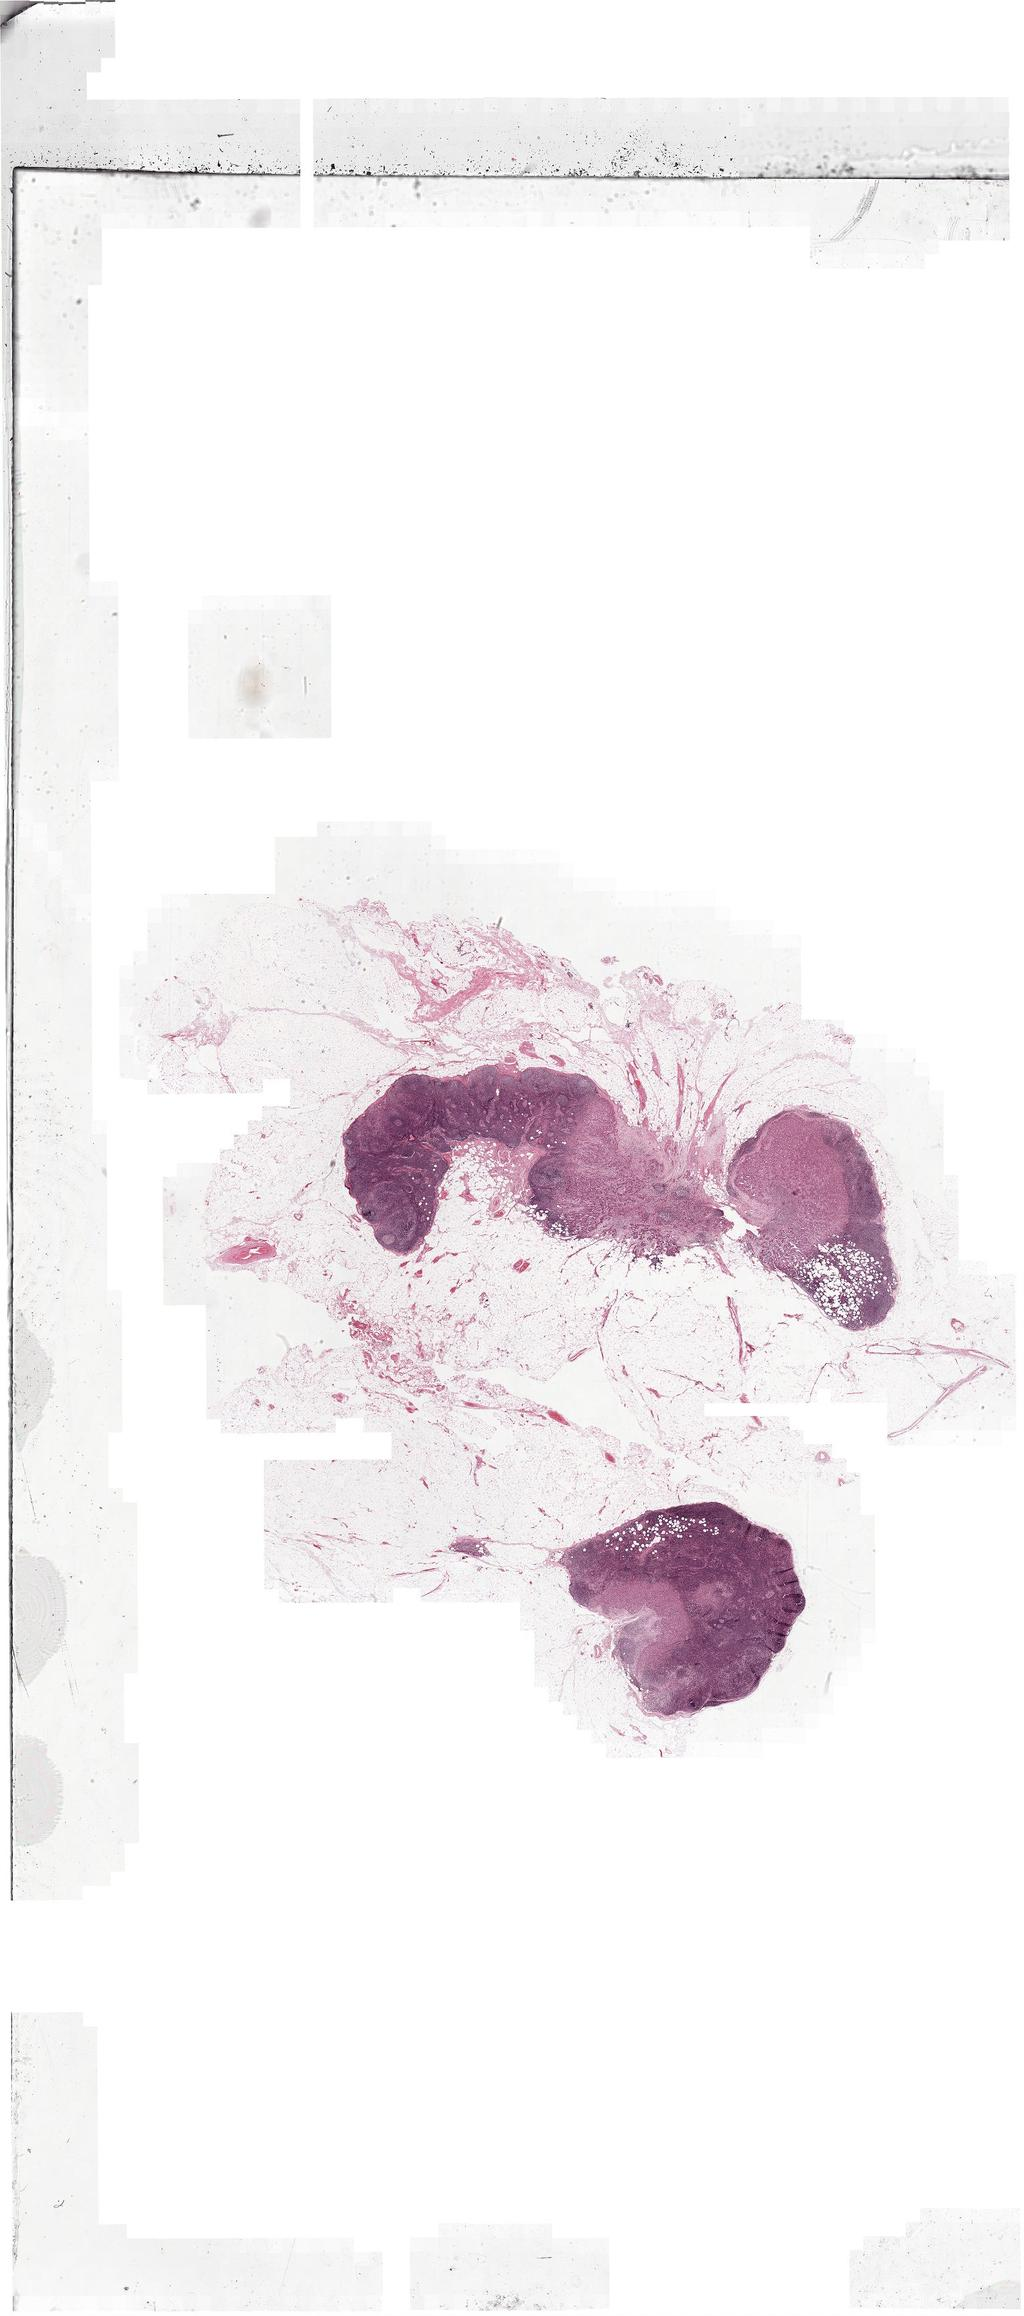


Observation: [(25, 240)]
Thought:[DEBUG] Agent action decided: zoom
Thought: The region_of_interest tool returned coordinates (25, 240) as a suspicious area on the thumbnail. I should now use the zoom tool to get high resolution patches around that location from the whole slide image.

Action: zoom
Action Input: {"thumbnail_coords": [(25, 240)], "wsi_path": "/content/drive/My Drive/Colab Notebooks/Dataset/tumor/tumor_011.tif"}

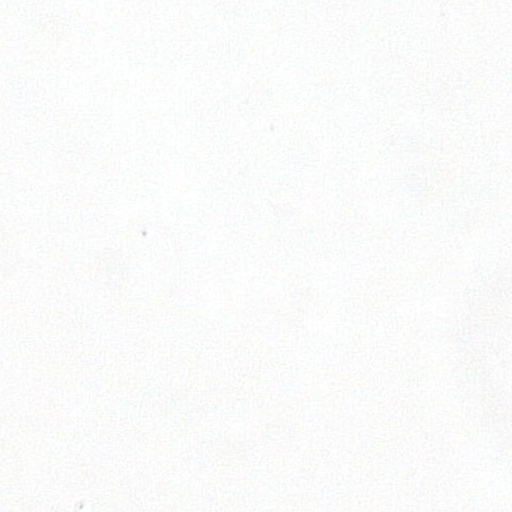


Observation: {'patches': ['Patch at (2387, 68143)'], 'images': [<PIL.Image.Image image mode=RGB size=512x512 at 0x78D9CE62F910>]}
Thought:[DEBUG] Agent action decided: patch_classification
Thought: The zoom tool returned a high resolution patch image from the coordinates (25, 240) on the whole slide image. I should now pass this patch to the patch_classification tool to check if it contains cancer.

Action: patch_classification
Action Input: "['Patch at (2387, 68143)']"

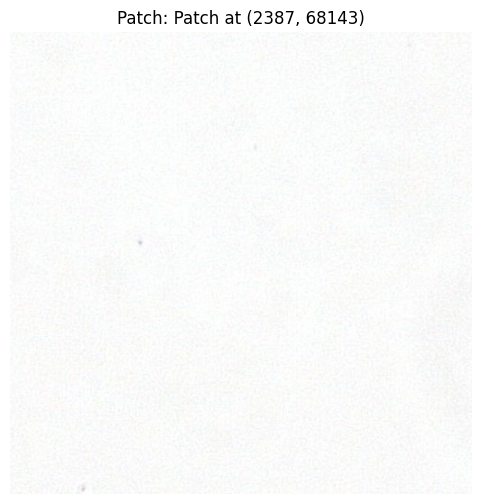


Observation: {'Patch at (2387, 68143)': 'non-cancerous (confidence: 1.00)'}
Thought:[DEBUG] Agent finished with output: {'output': 'Based on analyzing the thumbnail and whole slide image using the provided tools, the slide tumor_011.tif does not appear to contain cancer. The region_of_interest tool identified one potentially suspicious region, but when that region was extracted at high resolution and analyzed using the patch_classification tool, it was determined to be non-cancerous with high confidence.'}
Thought: The patch_classification tool determined that the zoomed patch at coordinates (2387, 68143) is non-cancerous with high confidence. Since the region_of_interest tool only flagged one suspicious area, and that area turned out to be non-cancerous upon further analysis, I can conclude my analysis of this slide.

Final Answer: Based on analyzing the thumbnail and whole slide image using the provided tools, the slide tumor_011.tif does not appear to contain cancer. The region_of_

In [ ]:
from pathlib import Path
from langchain.callbacks import get_openai_callback

#dataset_folder_path = "/content/drive/MyDrive/Dataset"
dataset_folder_path = "/content/drive/My Drive/Colab Notebooks/Dataset"

tumor_110_thumbnail = str(Path(dataset_folder_path) / "thumbnails" / "tumor_011.jpg")
tumor_110_WSI = str(Path(dataset_folder_path) / "tumor" / "tumor_011.tif")

query = f"""
Analyze the slide for cancer.
The thumbnail is located at: {tumor_110_thumbnail}.
The WSI is located at: {tumor_110_WSI}
Use the region_of_interest tool to find suspicious areas (output: list of [x, y] coordinates),
then pass that to the zoom tool along with the WSI path as:

{{"thumbnail_coords": [...], "wsi_path": "..."}}

Finally, use patch_classification to check the patches for cancer.
"""
with get_openai_callback() as cb:
  response = agent.invoke({"input": query}, callbacks=[token_counter])

print("Prompt tokens: ", cb.prompt_tokens)
print("Completion tokens: ", cb.completion_tokens)
print("Total tokens: ", cb.total_tokens)

for record in token_counter.get_summary():
    print(record)